In [1]:
#Import Necessary Library's
import pandas as pd
import numpy as np
import re
import json
import folium
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from pathlib import Path
import seaborn as sn
import matplotlib.pyplot as pyplot

In [2]:
#Set up file path
data_folder = Path("./Data/")

In [3]:
HappinessFile = data_folder / "2019 Happiness Data.csv"

#Import Data to Pandas DataFrame
happinessDF = pd.read_csv(HappinessFile)
happinessDF2 = happinessDF.drop(happinessDF.columns.difference(["Country or region", "Score"]), axis = 1)
happinessDF2.rename(columns = {"Score": "Happiness Score", "Country or region": "Country Name"}, inplace = True)
happinessDF2.set_index("Country Name", inplace = True)

In [4]:
#Import Data
FreedomFile = data_folder / "economic_freedom_index2019_data.csv"

#Import Data to Pandas DataFrame
economicFreedomDF = pd.read_csv(FreedomFile,encoding='latin-1')
economicFreedomDF = economicFreedomDF.dropna(subset=["World Rank"])
economicFreedomDF2 = economicFreedomDF.drop(economicFreedomDF.columns.difference(["Country Name","2019 Score","Financial Freedom", "Population (Millions)", "Unemployment (%)", "Inflation (%)"]), axis = 1)
economicFreedomDF2.rename(columns = {"2019 Score": "Economic Freedom"}, inplace = True)
economicFreedomDF2.set_index("Country Name", inplace = True)

In [5]:
#Import Data
GDPData = data_folder / "GDPfinal.json"

# read in json file of GDP data 
GDPDF = pd.read_json(GDPData)

GDPDF2 = GDPDF.drop(GDPDF.columns.difference(["Country","Growth Rate", "GDP (IMF)", "GDP Per Capita"]), 1)
GDPDF2.drop(GDPDF2.index[GDPDF2["GDP (IMF)"] == "-"], inplace=True)
GDPDF2.dropna(subset=["Growth Rate"], inplace = True)
GDPDF2.rename(columns = {"GDP (IMF)": "GDP (Billions)", "Country": "Country Name"}, inplace = True)
GDPDF2.set_index("Country Name", inplace = True)

for rowlabel, rowseries in GDPDF2.iterrows():
    GDPDF2.loc[rowlabel, "GDP Per Capita"] = float(re.sub("[^0-9.]", "", GDPDF2.loc[rowlabel, "GDP Per Capita"]))
    GDPDF2.loc[rowlabel, "Growth Rate"] = float(re.sub("[^0-9.]", "", GDPDF2.loc[rowlabel, "Growth Rate"]))
    
    gdp = GDPDF2.loc[rowlabel, "GDP (Billions)"]
    gdpMag = gdp[-2:]
    gdpClean = float(re.sub("[^0-9.]", "", gdp))
    
    if gdpMag == "Tn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean * 1000
    elif gdpMag == "Bn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean
    elif gdpMag == "Mn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean/1000

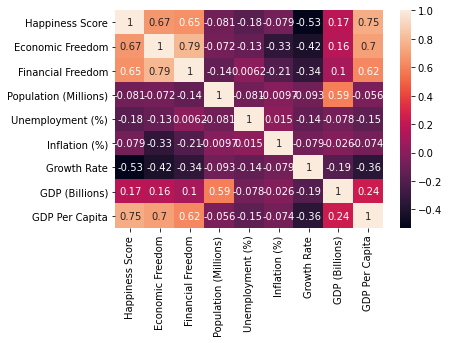

In [6]:
df = happinessDF2.join(economicFreedomDF2, on = 'Country Name', how = "inner")
df_final = df.join(GDPDF2, on = 'Country Name', how = "inner")
df_final = df_final.astype(float)
corrMatrix = df_final.corr(method = "pearson")
sn.heatmap(corrMatrix, annot=True)
pyplot.show()

The purpose of our analysis is to see whether we're able to predict Happiness Score by some economic factors. The above correlation matrix can help us perform some exploratory data analysis. By looking at the top row, we can see which variables are most correlated with Happiness Score, our response. The variables that look most important seem to be GDP, economic freedom, financial freedom, and GDP per capita. We can also look to see if there is any early indication of multicollinearity if we were to want to try and fit a multiple linear regression with multiple predictors. We're looking for correlation between predictors of greater than or equal to 0.8. We'll verify this in greater detail later in the analysis. 

We can begin our analysis by fitting a simple linear regression on each of the predictors that we saw could be good at predicting happiness score. 

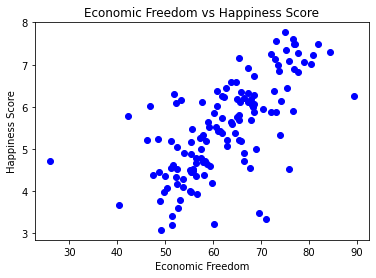

In [7]:
pyplot.plot(df_final["Economic Freedom"],df_final["Happiness Score"], "bo")
pyplot.xlabel("Economic Freedom")
pyplot.ylabel("Happiness Score")
pyplot.title("Economic Freedom vs Happiness Score")
pyplot.show()

This scatterplot looks linear so we can fit a linear model to the data and no transformation is necessary.

In [8]:
x = df_final["Economic Freedom"]
y = df_final["Happiness Score"]

A = np.vstack([x, np.ones(len(x))]).T

In [9]:
model, SSE = np.linalg.lstsq(A, y, rcond=None)[:2]

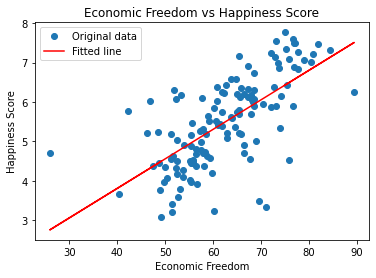

In [10]:
_ = pyplot.plot(x, y, 'o', label='Original data')
_ = pyplot.plot(x, model[0]*x + model[1], 'r', label='Fitted line')
_ = pyplot.xlabel("Economic Freedom")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("Economic Freedom vs Happiness Score")
_ = pyplot.legend()
pyplot.show()

In [11]:
#Find R^2 of model
rSquare2 = 1 - SSE[0] / sum((y - y.mean())**2) 
rSquare2

0.45229802223883764

The R^2 of this model is 0.4523. This tells us that 45.23% of the variation in happiness score can be explained by economic freedom. 

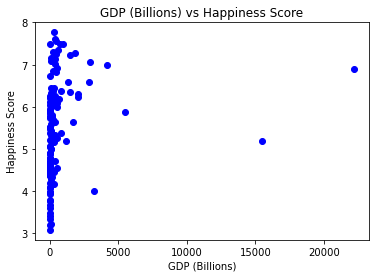

In [12]:
#Second Model
pyplot.plot(df_final["GDP (Billions)"],df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("GDP (Billions)")
pyplot.ylabel("Happiness Score")
pyplot.title("GDP (Billions) vs Happiness Score")
pyplot.show()

The second variable we wish to explore is GDP in billions of dollars. This scatterplot is not that great and differs from what we would expect by many orders of magnitude. We should take a log() transformation. 

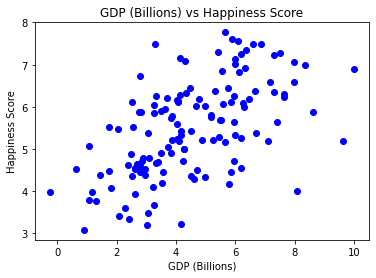

In [13]:
#Transform GDP Billions
pyplot.plot(np.log(df_final["GDP (Billions)"]),df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("GDP (Billions)")
pyplot.ylabel("Happiness Score")
pyplot.title("GDP (Billions) vs Happiness Score")
pyplot.show()

The log() transformation fixes our scatterplot. We can now fit a linear model with log(GDP). 

In [14]:
x2 = np.log(df_final["GDP (Billions)"])

A2 = np.vstack([x2, np.ones(len(x2))]).T

In [15]:
model2, SSE2 = np.linalg.lstsq(A2, y, rcond=None)[:2]

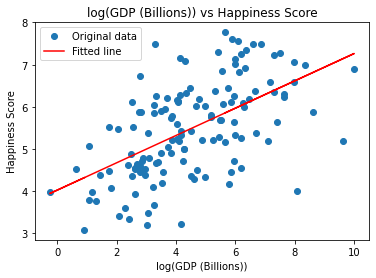

In [16]:
_ = pyplot.plot(x2, y, 'o', label='Original data')
_ = pyplot.plot(x2, model2[0]*x2 + model2[1], 'r', label='Fitted line')
_ = pyplot.xlabel("log(GDP (Billions))")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("log(GDP (Billions)) vs Happiness Score")
_ = pyplot.legend()
pyplot.show()


##### Have to take the exponential of whatever you predict

In [17]:
#Finding R^2 for second model
rSquare2 = 1 - SSE2[0] / sum((y - y.mean())**2) 
rSquare2

0.3190029292906227

The R^2 for this model is 0.3190. This tells us that 31.9% of the variation in happiness score can be explained by log(GDP). 

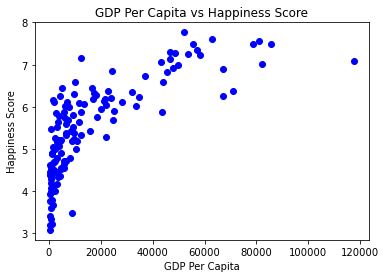

In [18]:
#Third Model
pyplot.plot(df_final["GDP Per Capita"],df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("GDP Per Capita")
pyplot.ylabel("Happiness Score")
pyplot.title("GDP Per Capita vs Happiness Score")
pyplot.show()

The scattplot for GDP per capita looks to be off by multiple orders of magnitude like the initial scatterplot for the second model. We can take another log() transformation. 

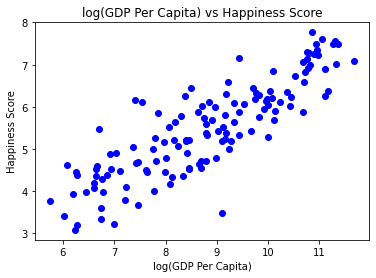

In [19]:
#Third Model
pyplot.plot(np.log(df_final["GDP Per Capita"]),df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("log(GDP Per Capita)")
pyplot.ylabel("Happiness Score")
pyplot.title("log(GDP Per Capita) vs Happiness Score")
pyplot.show()

Again, log() transformation fixes our data and we're ready to fit a linear model to the data. 

In [20]:
x3 = np.log(df_final["GDP Per Capita"])

A3 = np.vstack([x3, np.ones(len(x3))]).T

In [21]:
model3, SSE3 = np.linalg.lstsq(A3, y, rcond=None)[:2]

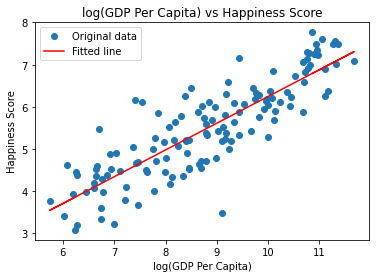

In [22]:
_ = pyplot.plot(x3, y, 'o', label='Original data')
_ = pyplot.plot(x3, model3[0]*x3 + model3[1], 'r', label='Fitted line')
_ = pyplot.xlabel("log(GDP Per Capita)")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("log(GDP Per Capita) vs Happiness Score")
_ = pyplot.legend()
pyplot.show()


##### Have to take the exponential of whatever you predict

In [23]:
#Finding R^2 for third model
rSquare3 = 1 - SSE3[0] / sum((y - y.mean())**2) 
rSquare3

0.7306931295161503

The R^2 for this model is 0.7306. This tells us that 73.06% of the variation in happiness score can be explained by log(GDP per capita). 

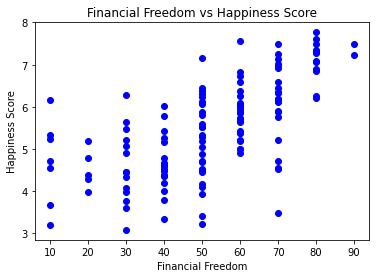

In [24]:
#Fourth Model
pyplot.plot(df_final["Financial Freedom"],df_final["Happiness Score"], "bo")
pyplot.xlabel("Financial Freedom")
pyplot.ylabel("Happiness Score")
pyplot.title("Financial Freedom vs Happiness Score")
pyplot.show()

It seems like there's a bit of a quadratic trend in the data, so we can take a square transformation for financial freedom. 

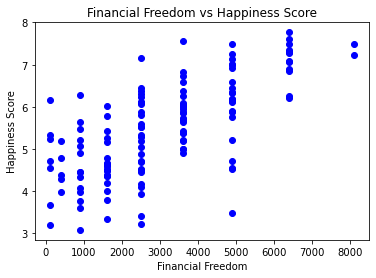

In [25]:
#Fourth Model
pyplot.plot(df_final["Financial Freedom"]**2,df_final["Happiness Score"], "bo")
pyplot.xlabel("Financial Freedom")
pyplot.ylabel("Happiness Score")
pyplot.title("Financial Freedom vs Happiness Score")
pyplot.show()

This looks a bit better. We can fit a linear model using this transformation.

In [26]:
x4 = df_final["Financial Freedom"]**2

A4 = np.vstack([x4, np.ones(len(x4))]).T

In [27]:
model4, SSE4 = np.linalg.lstsq(A4, y, rcond=None)[:2]

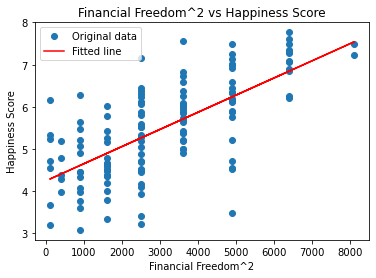

In [28]:
_ = pyplot.plot(x4, y, 'o', label='Original data')
_ = pyplot.plot(x4, model4[0]*x4 + model4[1], 'r', label='Fitted line')
_ = pyplot.xlabel("Financial Freedom^2")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("Financial Freedom^2 vs Happiness Score")
_ = pyplot.legend()
pyplot.show()


##### Have to take the square root of whatever you predict

In [29]:
#Finding R^2 for fourth model
rSquare4 = 1 - SSE4[0] / sum((y - y.mean())**2) 
rSquare4

0.4696449491119524

The r^2 for this model is 0.4696. This tells us that 46.96% of the variation in happiness score can be explained by financial freedom^2. 

In [30]:
# for multiple linear regression model 
X = np.transpose(np.array([np.log(df_final["GDP (Billions)"]), df_final["Economic Freedom"], np.log(df_final["GDP Per Capita"]),(df_final['Financial Freedom'])**2]))
reg5 = LinearRegression().fit(X, y)
# r^2 for mlr model
reg5.score(X, y)

0.7423647799897591

This multiple linear regression model gives an r^2 of 0.7423. This tells us that 74.23% of the variation in happiness score can be explained by financial freedom^2, log(GDP per capita), log(GDP), and economic freedom. We still need to check for multicollinearity. 

In [31]:
# calculating VIF for each variable in the mlr

X = df_final[['GDP (Billions)', 'Economic Freedom', 'GDP Per Capita', 'Financial Freedom']]
X["GDP (Billions)"] = np.log(X["GDP (Billions)"])
X["GDP Per Capita"] = np.log(X["GDP Per Capita"])
X["Financial Freedom"] = (X["Financial Freedom"])**2

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data

<ipython-input-31-76ab76052adb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["GDP (Billions)"] = np.log(X["GDP (Billions)"])
<ipython-input-31-76ab76052adb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["GDP Per Capita"] = np.log(X["GDP Per Capita"])
<ipython-input-31-76ab76052adb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,feature,VIF
0,GDP (Billions),10.716268
1,Economic Freedom,83.625367
2,GDP Per Capita,101.100528
3,Financial Freedom,5.776162


Economic freedom and financial freedom are extrememly correlated. We need to drop one of these variables from the model. Since economic freedom did not require a transformation and had a better r^2 in its own simple linear regression model, we will drop financial freedom^2. 

In [32]:
X = np.transpose(np.array([np.log(df_final["GDP (Billions)"]), df_final["Economic Freedom"], np.log(df_final["GDP Per Capita"])]))
reg6 = LinearRegression().fit(X, y)
# r^2 for mlr model
reg6.score(X, y)

0.7340488567293965

In [33]:
# calculating VIF for each variable in the mlr

X = df_final[['GDP (Billions)', 'Economic Freedom', 'GDP Per Capita']]
X["GDP (Billions)"] = np.log(X["GDP (Billions)"])
X["GDP Per Capita"] = np.log(X["GDP Per Capita"])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data

<ipython-input-33-afe632ac7367>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["GDP (Billions)"] = np.log(X["GDP (Billions)"])
<ipython-input-33-afe632ac7367>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["GDP Per Capita"] = np.log(X["GDP Per Capita"])


,feature,VIF
0,GDP (Billions),10.396681
1,Economic Freedom,77.619643
2,GDP Per Capita,100.453746


Again, we obtain high VIFs from our model. We could try removing GDP per capita since it has the highest VIF and see the results. 

In [34]:
X = np.transpose(np.array([np.log(df_final["GDP (Billions)"]), df_final["Economic Freedom"]]))
reg7 = LinearRegression().fit(X, y)
# r^2 for mlr model
reg7.score(X, y)

0.5532027125362431

In [35]:
# calculating VIF for each variable in the mlr

X = df_final[['GDP (Billions)', 'Economic Freedom']]
X["GDP (Billions)"] = np.log(X["GDP (Billions)"])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data

<ipython-input-35-3719bca943fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["GDP (Billions)"] = np.log(X["GDP (Billions)"])


,feature,VIF
0,GDP (Billions),7.51507
1,Economic Freedom,7.51507


In [36]:
model3[0]

0.6341403583510405

Again, we obtain high VIFs. The best predictors of happiness score all seem to have multicollinearity so we will resort back to a simple linear regression model. The best model that we found above was the model which used the log() of GDP per capita. Overall, the best predictor of happiness that we found was log(GDP per capita). We had to take a log() transformation because GDP per capita differed by many orders of magnitude over the range of happiness score. The coefficient predicton for this model was 0.634. This tells us that for a 1 unit increase in log(GDP per capita) in a country, the happiness score of that country is predicted to increase by 0.634. 

In [37]:
json_file = open(data_folder / "countries.geo.json", "r")
countries_geojson = json.load(json_file)

Here we load in the .geo.json file which will be used to create the map. We will be plotting happiness score on each country in the happiness dataset. 

In [38]:
countries_from_geojson = []
for item in countries_geojson["features"]:
    countries_from_geojson.append(item.get("properties", {}).get("name"))

This creates a list of countries in the .geo.json file. This way we're able to compare which countries are in the .json and which are in the happiness csv and see if any country names need to be changed or removed. 

In [39]:
print(sorted(countries_from_geojson))

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Southern and Antarctic Lands', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guatemala', 'Guinea', 'Guinea Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory 

In [40]:
# checking which countries are not in geojson
for _item in happinessDF['Country or region'].unique():
    if _item not in countries_from_geojson:
        print(_item)

United States
Singapore
Bahrain
Trinidad & Tobago
Mauritius
Serbia
Hong Kong
North Macedonia
Congo (Brazzaville)
Palestinian Territories
Congo (Kinshasa)
Comoros
Tanzania


United States, Trinidad & Tobago, North Macedonia, and Congo (Kinshasa) need to be renamed to match what is in the happinessDF. Sinapore, Bahrain, Mauritus, Serbia, Hong Kong, Palestinian Territories, Congo (Brazzaville), and Tanzania need to be removed since they are not in the happinessDF.

In [41]:
happinessDF1 = happinessDF.replace({"United States": "United States of America", "Trinidad & Tobago": "Trinidad and Tobago", "North Macedonia": "Macedonia", 
"Congo (Kinshasa)": "Democratic Republic of the Congo"})

happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Singapore']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Bahrain']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Mauritius']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Serbia']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Hong Kong']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Palestinian Territories']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Congo (Brazzaville)']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Tanzania']

country_df = happinessDF1[['Country or region', 'Score']]
country_df = country_df.rename(columns={"Country or region": "Name"})

Here we change the names of countries to match what they hare in the happinessDF. We also remove countries that we don't have shape properties for. 

In [42]:
for item in countries_geojson["features"]:
    key = item.get("properties", {}).get("name")
    score = re.findall(r'(\d\.\d+)|$', str(country_df[country_df['Name']==key]['Score']))[0]
    content = f"Name: {key} | Happiness Score: {str(score)}"
    item['properties']['content'] = content

Here we are creating what will be displayed when the user hovers over a country in the map. We will display the country name and happiness score for the countries that have a happiness score. 

In [43]:
df_map = folium.Map(
    location=[0,0],
    zoom_start=3
)

tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(df_map)


choropleth = folium.Choropleth(
    geo_data=countries_geojson,
    key_on='feature.properties.name',
    data=country_df, 
    columns=['Name', 'Score'], 
    fill_color='PuBuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    legend_name="Happiness Score"
).add_to(df_map)

folium.LayerControl().add_to(df_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['content'], labels=False,
                                   style=('background-color: grey; color: white;'))
)

df_map

This is the code we use to create the choropleth map for happiness score by country. A legend for what the shading of each country means and what happiness score this corresponds to can be viewed in the top right. The dark grey countries are those which don't have a happiness score. This map gives us a good indication of which countries and overall regions are the happiest. By the legend we can see that the happiest countries are those that are filled with a darker green. Going by this, it seems like the overall happiest part of the work is Scandinavia as Norway, Sweden, Denmark, and Finland are all dark green. Overall, Europe is also a very happy place, especially central Europe which include countries like Switzerland, Austria, Germany, Holland, Belgium, and the Czech Republic. Oceania which includes Austrailia and New Zealand also seems to be a very happy region overall. The final region that seems to be the most happy is most of North and Central America. 